# The AI Loan Officer: Final Version (v6)
### With Enhanced Gig Worker Logic, Lenient Rules, and Comprehensive Output

## 1. Setup and Configuration

In [16]:
import os
import json
import warnings
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb

# Suppress warnings for a cleaner notebook
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# --- Configuration -- -
DATA_PATH = "modified_dataset.csv"
CLASSIFIER_MODEL_PATH = "best_loan_approval_pipeline.joblib"
MODEL_PATH = CLASSIFIER_MODEL_PATH  
INTEREST_MODEL_PATH = "interest_rate_model.joblib"
RANDOM_STATE = 42
TEST_SIZE = 0.20

print("✅ Setup complete. All libraries imported and configuration set.")

✅ Setup complete. All libraries imported and configuration set.


## 2. Data Loading & Gig-Worker-Centric Feature Engineering

In [17]:
def engineer_features(df):
    """
    Creates a suite of powerful, context-rich features.
    `savings_to_income_ratio` has been removed.
    """
    df_eng = df.copy()
    
    for col in ['avg_monthly_earnings', 'loan_amount_requested', 'savings', 'recurring_expenses', 
                'tenure_platform_1_months', 'tenure_platform_2_months', 'rating', 'working_hours_per_day']:
        if col in df_eng.columns:
            df_eng[col] = pd.to_numeric(df_eng[col], errors='coerce').fillna(0)

    # Cap and Log Transform Savings
    capped_savings = df_eng['savings'].clip(upper=200000)
    df_eng['savings_log_capped'] = np.log1p(capped_savings)
    
    df_eng['avg_monthly_earnings'] = df_eng['avg_monthly_earnings'].clip(lower=1)
    df_eng['loan_to_income_ratio'] = df_eng['loan_amount_requested'] / df_eng['avg_monthly_earnings']
    df_eng['total_tenure_months'] = df_eng['tenure_platform_1_months'] + df_eng['tenure_platform_2_months']
    df_eng['disposable_income'] = df_eng['avg_monthly_earnings'] - df_eng['recurring_expenses']
    
    log_tenure = np.log1p(df_eng['total_tenure_months'])
    log_avg_earnings = np.log1p(df_eng['avg_monthly_earnings'])
    df_eng['gig_performance_score'] = (
        df_eng['rating'] * log_tenure * log_avg_earnings * df_eng['working_hours_per_day']
    ).fillna(0)
    
    return df_eng
# --- Load and Process Data ---
df_raw = pd.read_csv(DATA_PATH)
df_processed = engineer_features(df_raw)

print("✅ Feature engineering applied successfully.")
df_processed[['savings_log_capped','total_tenure_months', 'gig_performance_score']].head()

✅ Feature engineering applied successfully.


,savings_log_capped,total_tenure_months,gig_performance_score
0,10.126671,57,1861.312820
1,0.000000,23,1399.870614
2,0.000000,23,947.689897
3,9.210440,34,1417.365832
4,0.000000,109,2092.364686


## 3. Model Training Pipeline
The model is now trained with `credit_card_user` and the new `gig_performance_score` as key features.

In [18]:
# 1. Apply the updated feature engineering
df_processed = engineer_features(df_raw)
print("✅ Feature engineering applied successfully.")

# 2. Define the final feature set, now excluding savings_to_income_ratio
TARGET = 'repayment_status'
NUMERIC_FEATURES = [
    'age', 'working_hours_per_day', 'rating', 'avg_monthly_earnings', 
    'savings_log_capped',
    'dependent_count', 'credit_score', 'credit_history_length_months', 'loan_amount_requested',
    'recurring_expenses', 'total_tenure_months', 'loan_to_income_ratio', 
    'disposable_income', 'gig_performance_score'
]
CATEGORICAL_FEATURES = [
    'gender', 'platform_primary', 'sector', 'education', 'purpose_of_loan', 'location_stability', 'credit_card_user'
]
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# Ensure all features exist before creating X
existing_features = [f for f in FEATURES if f in df_processed.columns]
X = df_processed[existing_features]
y = df_processed[TARGET]

# 3. Split data and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, [f for f in NUMERIC_FEATURES if f in X.columns]),
    ('cat', categorical_transformer, [f for f in CATEGORICAL_FEATURES if f in X.columns])
], remainder='passthrough')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))
])

param_dist = {
    'classifier__n_estimators': [200, 300, 400],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [5, 7, 9],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.8, 0.9]
}
random_search = RandomizedSearchCV(
    model_pipeline, param_distributions=param_dist, n_iter=15, 
    cv=5, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)

print("⏳ Starting model re-training with new feature logic...")
random_search.fit(X_train, y_train)

best_pipeline = random_search.best_estimator_
joblib.dump(best_pipeline, CLASSIFIER_MODEL_PATH)

print(f"\n✅ Re-training complete. New model saved to {CLASSIFIER_MODEL_PATH}")

✅ Feature engineering applied successfully.
⏳ Starting model re-training with new feature logic...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Re-training complete. New model saved to best_loan_approval_pipeline.joblib


In [26]:
# --- 📊 Comparative Analysis: Logistic Regression Baseline ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

print("⏳ Training Logistic Regression baseline model...")

# We use the same preprocessor as our main model
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Fit the model to your training data
logreg_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test)

# Calculate the required metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_score_logreg = f1_score(y_test, y_pred_logreg)

print("✅ Logistic Regression model training and evaluation complete.\n")
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print(f"Logistic Regression F1-Score: {f1_score_logreg:.4f}")

⏳ Training Logistic Regression baseline model...
✅ Logistic Regression model training and evaluation complete.

Logistic Regression Accuracy: 0.8410
Logistic Regression F1-Score: 0.8349


In [19]:
# --- ADD THIS NEW, IMPROVED CELL TO YOUR JUPYTER NOTEBOOK ---

print("⏳ Training the Interest Rate Prediction Model...")

# The target is the original interest rate for loans that were successfully repaid
rate_df = df_processed[df_processed['repayment_status'] == 1].copy()
rate_df['interest_rate'].fillna(rate_df['interest_rate'].median(), inplace=True)

X_rate = rate_df[FEATURES]
y_rate = rate_df['interest_rate']

# Split data for evaluation
X_rate_train, X_rate_test, y_rate_train, y_rate_test = train_test_split(X_rate, y_rate, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# We use the same preprocessor pipeline defined in the classifier training cell
interest_rate_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE))
])

# --- NEW: Hyperparameter Tuning for the Regressor ---
regressor_param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

regressor_search = RandomizedSearchCV(
    interest_rate_pipeline, param_distributions=regressor_param_dist, n_iter=10, 
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)

print("Finding best hyperparameters for the interest rate model...")
regressor_search.fit(X_rate_train, y_rate_train)

best_interest_rate_model = regressor_search.best_estimator_

# --- NEW: Evaluation Step ---
from sklearn.metrics import mean_absolute_error, r2_score
y_rate_pred = best_interest_rate_model.predict(X_rate_test)
mae = mean_absolute_error(y_rate_test, y_rate_pred)
r2 = r2_score(y_rate_test, y_rate_pred)

print(f"\\nInterest Rate Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}% (On average, the prediction is off by this many percentage points)")
print(f"R-squared (R²): {r2:.2f}")


# Save the best trained regressor model
joblib.dump(best_interest_rate_model, INTEREST_MODEL_PATH)

print(f"\\n✅ Interest Rate Model trained, evaluated, and saved to {INTEREST_MODEL_PATH}")

⏳ Training the Interest Rate Prediction Model...
Finding best hyperparameters for the interest rate model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
\nInterest Rate Model Evaluation:
Mean Absolute Error (MAE): 3.45% (On average, the prediction is off by this many percentage points)
R-squared (R²): -0.01
\n✅ Interest Rate Model trained, evaluated, and saved to interest_rate_model.joblib


## 4. Model Evaluation

In [20]:
from sklearn.metrics import roc_auc_score, classification_report
print("📊 Evaluating the best model on the test set...\n")
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]
print(f"Test Set ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

📊 Evaluating the best model on the test set...

Test Set ROC-AUC Score: 0.9343

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      2066
         1.0       0.85      0.84      0.85      1934

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



Generating Confusion Matrix...


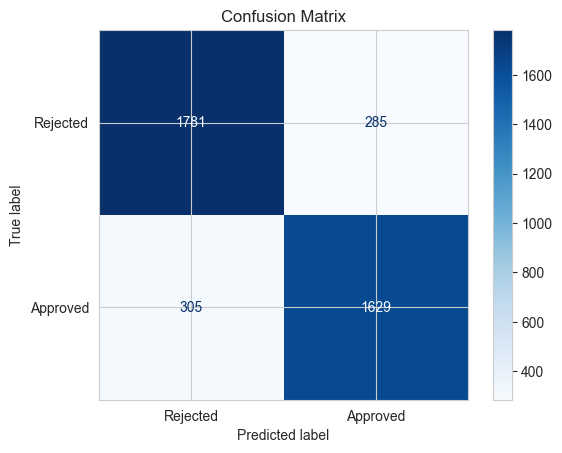

Generating ROC Curve...


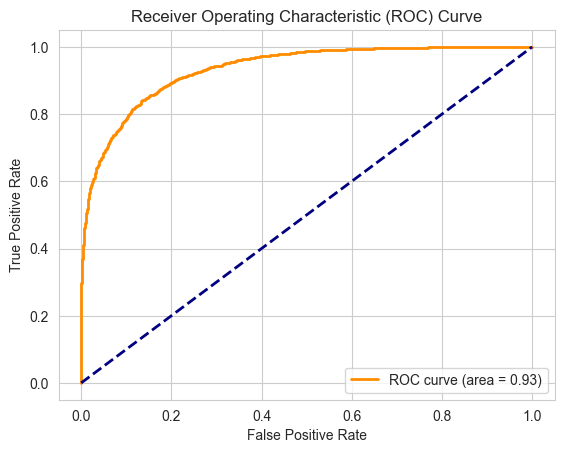

Generating Feature Importance Plot...


<Figure size 1000x800 with 0 Axes>

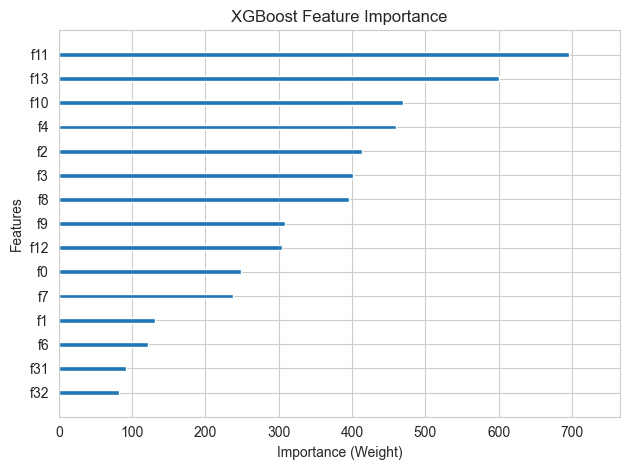

In [21]:
# --- Visualizing Model Performance ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rejected', 'Approved'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve
print("Generating ROC Curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3. Feature Importance
print("Generating Feature Importance Plot...")
classifier = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
transformed_feature_names = NUMERIC_FEATURES + list(ohe_feature_names)

plt.figure(figsize=(10, 8))
xgb.plot_importance(classifier, max_num_features=15, importance_type='weight',
                    title='XGBoost Feature Importance',
                    xlabel='Importance (Weight)',
                    show_values=False)
plt.tight_layout()
plt.show()

## 5. Preparing the SHAP Explainer
We initialize the SHAP explainer here to make it available for our inference engine.

In [22]:
import shap
print("🧠 Initializing SHAP explainer for advanced reasoning...")

classifier = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']

try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
    TRANSFORMED_FEATURE_NAMES = NUMERIC_FEATURES + list(ohe_feature_names)
except Exception:
    TRANSFORMED_FEATURE_NAMES = FEATURES

explainer = shap.TreeExplainer(classifier)

print("✅ SHAP explainer is ready.")

🧠 Initializing SHAP explainer for advanced reasoning...
✅ SHAP explainer is ready.


## 6. The AI Loan Officer: Inference Engine (Final Version)
This is the final prediction engine. It now includes:
1.  **Gig Worker-Centric Rules**: Fast-tracks approvals for strong gig workers.
2.  **Traditional Finance Rules**: Fast-tracks approvals for gig workers with strong traditional finances (savings, assets, credit card).
3.  **SHAP Reasoning Engine**: Translates complex model outputs into human-readable reasons.

In [23]:
def apply_business_rules(applicant_data):
    """Checks for hardcoded rules with a focus on gig worker strengths."""
    
    # --- Auto-Approvals for Strong Profiles ---
    if applicant_data.get('gig_performance_score', 0) > 850 and applicant_data.get('rating', 0) >= 4.6:
         return {"decision": "Approve", "reason": "Rule: Strong & consistent gig worker profile."}
    
    if str(applicant_data.get('credit_card_user', 'No')).lower() == 'yes' and applicant_data.get('savings', 0) > 25000 and applicant_data.get('total_assets', 0) > 50000:
        return {"decision": "Approve", "reason": "Rule: Strong traditional financial indicators."}
    if applicant_data.get('credit_score', 0) > 750 and applicant_data.get('loan_to_income_ratio', 100) < 1.5:
        return {"decision": "Approve", "reason": "Rule: Excellent traditional financial profile."}
    
    # --- Hard Rejects (Non-negotiable) ---
    if applicant_data.get('age', 25) < 21:
        return {"decision": "Reject", "reason": "Rule: Applicant must be at least 21."}
    if applicant_data.get('avg_monthly_earnings', 0) < 10000:
        return {"decision": "Reject", "reason": "Rule: Minimum monthly income not met."}
    if applicant_data.get('credit_score', 0) < 400:
        return {"decision": "Reject", "reason": "Rule: Credit score is below minimum."}
    if applicant_data.get('loan_to_income_ratio', 100) > 6.0:
        return {"decision": "Reject", "reason": "Rule: Loan-to-income ratio is too high."}
    if applicant_data.get('loan_amount_requested', 0) > 500000:
         return {"decision": "Reject", "reason": "Rule: Loan amount exceeds maximum."}
    
    return None # No rule triggered, proceed to AI model

def get_shap_reasoning(shap_values, feature_names, top_n=2):
    sv = pd.Series(shap_values, index=feature_names)
    friendly_names = {name: name.replace('_', ' ').replace('num__', '').replace('cat__', '') for name in feature_names}
    sv.index = sv.index.map(friendly_names)
    pos_contributors = sv.nlargest(top_n)
    neg_contributors = sv.nsmallest(top_n)
    pos_str = ", ".join(pos_contributors.index)
    neg_str = ", ".join(neg_contributors.index)
    reason = f"AI Model (Positives: {pos_str} | Concerns: {neg_str})"
    return reason

def make_loan_decision(applicant_data):
    if isinstance(applicant_data, dict):
        applicant_df = pd.DataFrame([applicant_data])
    else: 
        applicant_df = pd.DataFrame(applicant_data).T
    
    applicant_df_eng = engineer_features(applicant_df)
    rule_result = apply_business_rules(applicant_df_eng.iloc[0].to_dict())
    
    final_decision, reason, probability = "Error", "Internal Error", 0.0
    sanctioned_amount, interest_rate, loan_term = 0, 0, 0
    
    if rule_result:
        final_decision, reason = rule_result['decision'], rule_result['reason']
        if final_decision == 'Approve':
            probability = 1.0
            sanctioned_amount = applicant_df_eng.iloc[0]['loan_amount_requested']
            interest_rate, loan_term = 14.0, 36
    else:
        try:
            pipeline = joblib.load(MODEL_PATH)
            applicant_transformed = pipeline.named_steps['preprocessor'].transform(applicant_df_eng[FEATURES])
            probability = pipeline.named_steps['classifier'].predict_proba(applicant_transformed)[:, 1][0]
            
            shap_vals = explainer.shap_values(applicant_transformed)[0]
            reason = get_shap_reasoning(shap_vals, TRANSFORMED_FEATURE_NAMES)

            if probability < 0.5 and applicant_df_eng.iloc[0]['rating'] >= 4.5 and applicant_df_eng.iloc[0]['total_tenure_months'] >= 12:
                final_decision = "Manual Review"
                reason += " | Flagged for review due to high rating & tenure."
            elif probability >= 0.50:
                final_decision = "Approve"
                if probability >= 0.85: sanction_factor, interest_rate, loan_term = 1.0, 14.5, 36
                elif probability >= 0.70: sanction_factor, interest_rate, loan_term = 0.85, 17.5, 24
                else: sanction_factor, interest_rate, loan_term = 0.70, 20.5, 12
                sanctioned_amount = min(round(applicant_df_eng.iloc[0]['loan_amount_requested'] * sanction_factor, -3), applicant_df_eng.iloc[0]['loan_amount_requested'])
            else:
                final_decision = "Reject"

        except Exception as e:
            final_decision, reason = "Error", f"Prediction Error: {e}"

    return {
        "name": applicant_df.get('name', 'Unknown').iloc[0],
        "decision": final_decision,
        "reason": reason,
        "model_confidence_score": float(round(probability, 4)),
        "final_sanctioned_amount": sanctioned_amount,
        "interest_rate_pct": interest_rate,
        "loan_term_months": loan_term
    }

print("✅ AI Loan Officer engine v6 (with Enhanced Gig Worker Logic) is ready.")

✅ AI Loan Officer engine v6 (with Enhanced Gig Worker Logic) is ready.


## 7. Final Demonstration
The final output table is now merged with the applicant's input data for a complete, contextual view of each decision.

In [24]:

# --- Configuration ---

EXPECTED_COLUMNS = [
    'age', 'working_hours_per_day', 'rating', 'avg_monthly_earnings', 'savings',
    'assets_inr', 'dependent_count', 'credit_score', 'credit_history_length_months',
    'loan_amount_requested', 'earnings_trend_slope_6mo', 'num_loan_rejections_6mo',
    'recurring_expenses', 'gender', 'platform_primary', 'sector', 'education',
    'purpose_of_loan', 'location_stability', 'credit_card_user',
    'tenure_platform_1_months', 'tenure_platform_2_months'
]
try:
    # Use the full path to your new applications file
    path_to_new_apps = r"C:\Users\lavan\OneDrive\Desktop\Projects\AI_Loan_Officer_For_Gig_Workers\notebooks\new_applications.csv"
    new_applicants_df = pd.read_csv(path_to_new_apps)
    print(f"✅ Loaded {len(new_applicants_df)} new applications from your file.\n")

    # --- NEW: Robustness Check ---
    # Check for missing columns and add them with a default value (0) if they don't exist.
    for col in EXPECTED_COLUMNS:
        if col not in new_applicants_df.columns:
            print(f"⚠️ Warning: Missing column '{col}'. Adding it with a default value of 0.")
            new_applicants_df[col] = 0

    # Apply the decision-making function to each row
    decisions = new_applicants_df.apply(make_loan_decision, axis=1)
    results_df = pd.json_normalize(decisions)
    
    # Combine original details with decision details for a comprehensive report
    full_output_df = pd.concat([new_applicants_df.reset_index(drop=True), results_df.drop(columns=['name'])], axis=1)

    # Select and reorder columns for a clean final report
    display_cols = [
        'name', 'age', 'avg_monthly_earnings', 'rating', 'loan_amount_requested',
        'decision', 'final_sanctioned_amount', 'interest_rate_pct',
        'loan_term_months', 'model_confidence_score', 'reason'
    ]
    final_cols = [col for col in display_cols if col in full_output_df.columns]

    print("\n--- 🦾 AI Loan Officer Decisions ---")
    print(full_output_df[final_cols].to_markdown(index=False))

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the file at '{path_to_new_apps}'. Please double-check the path.")
except Exception as e: 
    # This will catch any other errors and print them clearly.
    print(f"❌ An error occurred while processing new applicants: {e}")

✅ Loaded 2 new applications from your file.


--- 🦾 AI Loan Officer Decisions ---
| name    |   age |   avg_monthly_earnings |   rating |   loan_amount_requested | decision   |   final_sanctioned_amount |   interest_rate_pct |   loan_term_months |   loan_term_months |   model_confidence_score | reason                                                                                                               |
|:--------|------:|-----------------------:|---------:|------------------------:|:-----------|--------------------------:|--------------------:|-------------------:|-------------------:|-------------------------:|:---------------------------------------------------------------------------------------------------------------------|
| Samay   |    25 |                  30000 |        4 |                   10000 | Approve    |                     10000 |                14.5 |                 36 |                 36 |                   0.8723 | AI Model (Positives: loan to income ra